In [1]:
# load libs 

import pickle
import os
import csv
import numpy as np
import sys
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
sys.path.append(r'/home/stud/afroehli/coding/util_scripts')
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

In [2]:
# objects of general use

imagenet_info = ImagenetSemanticInfo()

Stop node discovered


In [3]:
# define paths to load

root_path = '/home/stud/afroehli/coding/model_results/dinov2_vits14/'

inet_1k_val_path = (root_path + 'inet_1k_val_timm_trans.pkl', 'inet_1k_val')
inet_v2_70_path = (root_path + 'inet_v2_70_timm_trans.pkl', 'inet_v2_70')
inet_v2_mf_path = (root_path + 'inet_v2_mf_timm_trans.pkl', 'inet_v2_mf')
inet_v2_top_path = (root_path + 'inet_v2_top_timm_trans.pkl', 'inet_v2_top')
inet_r_path = (root_path + 'inet_r_timm_trans.pkl', 'inet_r')

loading_paths = [inet_1k_val_path, inet_v2_70_path, inet_v2_mf_path, inet_v2_top_path, inet_r_path]

inet_c_basepath = root_path + 'imagenet_c'
inet_c_corruptions = os.listdir(inet_c_basepath)
print(f'Imagenet-C corruptions: {inet_c_corruptions}')


Imagenet-C corruptions: ['spatter', 'brightness', 'gaussian_blur', 'defocus_blur', 'shot_noise', 'saturate', 'pixelate', 'gaussian_noise', 'snow', 'frost', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'speckle_noise', 'fog', 'contrast', 'zoom_blur', 'motion_blur', 'elastic_transform']


In [ ]:
# load pre-computed embeddings 

model_results = dict()

# first all simple datasets
for load_path, dict_name in loading_paths:
    with open(load_path, 'rb') as pkl_file:
        model_results[dict_name] = pickle.load(pkl_file)


# then all variations of imagenet-c
model_results['inet_c'] = dict()
for corruption in inet_c_corruptions:
    for sev_n in range(1, 6):
        if sev_n == 1: 
            model_results['inet_c'][corruption] = dict()

        with open(f'{inet_c_basepath}/{corruption}/sev_{sev_n}.pkl', 'rb') as pkl_file:
            model_results['inet_c'][corruption][sev_n] = pickle.load(pkl_file)

    

In [5]:

class_a_wnids = set(model_results['inet_r'].keys()) 
print(len(class_a_wnids))

inet_1k_val_mean = dict()
inet_1k_wnids = set(model_results['inet_1k_val'].keys())

class_a_distances = dict()

for wnid in inet_1k_wnids:
    inet_1k_val_mean[wnid] = np.mean(np.array(model_results['inet_1k_val'][wnid]), axis=0)

# for each common wnid, calculate distance to remaining 999 wnids
for class_a in class_a_wnids:

    inet_1k_wnids.remove(class_a)

    for wnid in inet_1k_wnids:
        class_a_dist = np.sum(np.abs(inet_1k_val_mean[class_a] - inet_1k_val_mean[wnid]))
        try: 
            class_a_distances[class_a].append((wnid, class_a_dist))
        except KeyError:
            class_a_distances[class_a] = []
            class_a_distances[class_a].append((wnid, class_a_dist))

    class_a_distances[class_a].sort(key = lambda la: la[1])
    inet_1k_wnids.add(class_a)

200


In [ ]:
# for each inet-r class find closest inet-1k-class

inet_r_mean = dict()
for wnid in class_a_wnids:
    inet_r_mean[wnid] = np.mean(np.array(model_results['inet_r'][wnid]), axis=0)

inet_r_dist = dict()

for class_a_wnid in class_a_wnids:
    for inet_wnid in inet_1k_wnids:
        try:
            inet_r_dist[class_a_wnid].append((inet_wnid, np.sum(np.abs(np.array(inet_r_mean[class_a_wnid]) - inet_1k_val_mean[inet_wnid]))))
        except KeyError:
            inet_r_dist[class_a_wnid] = [((inet_wnid, np.sum(np.abs(np.array(inet_r_mean[class_a_wnid]) - inet_1k_val_mean[inet_wnid]))))]

    inet_r_dist[class_a_wnid].sort(key=lambda x: x[1])



In [6]:
# store class split 

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_class_b_timm_trans.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for class_a in class_a_wnids:
        closest_class_wnid = class_a_distances[class_a][0][0]
        split_writer.writerow([class_a, closest_class_wnid])

In [ ]:
# store class-a, class-b, next nearest class 

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_b_next_nearest.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for class_a in class_a_wnids:
        closest_class_wnid = class_a_distances[class_a][0][0]
        second_closest_class_wnid = class_a_distances[class_a][1][0]
        split_writer.writerow([class_a, closest_class_wnid, second_closest_class_wnid])
        print([imagenet_info.wnid_to_classname[wnid] for wnid in [class_a, closest_class_wnid, second_closest_class_wnid]])

In [ ]:


with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_class_b_names_timm_trans.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for class_a in class_a_wnids:
        closest_class_name = imagenet_info.wnid_to_classname[class_a_distances[class_a][0][0]]
        class_a_name = imagenet_info.wnid_to_classname[class_a]
        split_writer.writerow([class_a_name, closest_class_name])

Stop node discovered


In [7]:
with open('/home/stud/afroehli/coding/dinov2_ood/storage/inet_r_neares_inet_1k.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for class_a in class_a_wnids:
        closest_class_name = imagenet_info.wnid_to_classname[inet_r_dist[class_a][0][0]]
        class_a_name = imagenet_info.wnid_to_classname[class_a]
        class_b_name = imagenet_info.wnid_to_classname[class_a_distances[class_a][0][0]]
        split_writer.writerow([class_a_name, closest_class_name, class_b_name])

In [5]:
class_a_b_map = dict()

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_class_b_timm_trans.csv', 'r') as class_split_table:
    closest_pairs_timm_trans = csv.reader(class_split_table, delimiter=';')

    for class_a, class_b in closest_pairs_timm_trans:
        class_a_b_map[class_a] = class_b


In [ ]:
with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_split.csv', 'r') as class_split_table:
    closest_pairs_old = csv.reader(class_split_table, delimiter=';')
    for class_a_old, class_b_old in closest_pairs_old:

        if class_a_b_map[class_a_old] != class_b_old:
            #print(f'Different class-B for: {class_a_old}, New = {class_a_b_map[class_a_old]}, Old = {class_b_old}')
            class_a_name = imagenet_info.wnid_to_classname[class_a_old]
            class_b_new_name = imagenet_info.wnid_to_classname[class_a_b_map[class_a_old]]
            class_b_old_name = imagenet_info.wnid_to_classname[class_b_old]
            print(f'Class-A: {class_a_name}, Class-B-Old: {class_b_old_name}, Class-B-New: {class_b_new_name}')

In [6]:
pat_first = re.compile('i.*not.*')
pat_second = re.compile('not.*and.*')
pat_both = re.compile('i.*and.*')
pat_none = re.compile('not.*not.*')

def calculate_in_stddev_stats(class_X_mean: np.array, store_dict: dict, class_a_mean, class_a_stddev, inet_1k_mean):

        inet_1k_class_a_dist = np.abs(inet_1k_mean - class_a_mean)
        class_X_class_a_dist = np.abs(class_X_mean - class_a_mean)

        for log_case in ['in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean']:


            if pat_first.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist <= class_a_stddev), 
                                                                            (inet_1k_class_a_dist > class_a_stddev)).tolist().count(True)
            elif pat_second.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist > class_a_stddev), 
                                                                (inet_1k_class_a_dist <= class_a_stddev)).tolist().count(True)
            elif pat_both.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist <= class_a_stddev), 
                                                                (inet_1k_class_a_dist <= class_a_stddev)).tolist().count(True)
            elif pat_none.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist > class_a_stddev), 
                                                                (inet_1k_class_a_dist > class_a_stddev)).tolist().count(True)
            else:
                raise ValueError(f'Logical case *{log_case}* was not matched')

In [7]:
## calculate statistics 

# fixed order of inet-wnids
inet_wnids_static = []

with open('/home/stud/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:
    class_index_reader = csv.reader(class_index_table, delimiter=';')
    for inet_class, _ in class_index_reader: 
        inet_wnids_static.append(inet_class)

stats_dict = dict()
random.seed(7)

# generate tuples of inet-wnids to compare 
compare_sets = []
for class_a in class_a_b_map.keys():
    class_b = class_a_b_map[class_a]

    rand_wnid = inet_wnids_static[random.randrange(0, len(inet_wnids_static))]
    while rand_wnid == class_a or rand_wnid == class_b:
        rand_wnid = inet_wnids_static[random.randrange(0, len(inet_wnids_static))]

    compare_sets.append((class_a, class_b, rand_wnid))

# whole imagenet-1k 
inet_1k_all_embeds = []
for wnid in inet_wnids_static:
    inet_1k_all_embeds.extend(model_results['inet_1k_val'][wnid])

inet_1k_mean = np.mean(np.array(inet_1k_all_embeds), axis = 0)


# over all class pairs: classA, classB, classRandom
for class_a, class_b, class_rand in compare_sets:

    comb_key = (class_a, class_b, class_rand)
    stats_dict[comb_key] = {'dim_nearer': {'inet_c': dict()}, 'l1_dist': {'inet_c': dict()}, 'dim_std': {'inet_c': dict()}}

    class_a_mean = np.mean(np.array(model_results['inet_1k_val'][class_a]), axis=0)
    class_a_stddev = np.std(np.array(model_results['inet_1k_val'][class_a]), axis=0)
    class_b_mean = np.mean(np.array(model_results['inet_1k_val'][class_b]), axis=0)
    class_r_mean = np.mean(np.array(model_results['inet_1k_val'][class_rand]), axis=0)

    # measurement 1: dims nearer than inet-mean
    stats_dict[comb_key]['dim_nearer']['class_b'] = (np.abs(class_b_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
    stats_dict[comb_key]['dim_nearer']['class_r'] = (np.abs(class_r_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)

    # measurement 2: l1-distance
    stats_dict[comb_key]['l1_dist']['inet_mean'] = np.sum(np.abs(inet_1k_mean - class_a_mean))
    stats_dict[comb_key]['l1_dist']['class_b'] = np.sum(np.abs(class_b_mean - class_a_mean))
    stats_dict[comb_key]['l1_dist']['class_r'] = np.sum(np.abs(class_r_mean - class_a_mean))

    # measurement 3: dims in std-dev of class-a
    
    for class_name, class_mean in [('class_b', class_b_mean), ('class_r', class_r_mean)]:
        stats_dict[comb_key]['dim_std'][class_name] = dict()
        calculate_in_stddev_stats(class_mean, stats_dict[comb_key]['dim_std'][class_name], 
                                  class_a_mean, class_a_stddev, inet_1k_mean)

   

    for res_key in ['inet_v2_70', 'inet_v2_mf', 'inet_v2_top', 'inet_r']:

        class_var_mean = np.mean(np.array(model_results[res_key][class_a]), axis=0)

        stats_dict[comb_key]['dim_nearer'][res_key] = (np.abs(class_var_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
        stats_dict[comb_key]['l1_dist'][res_key] = np.sum(np.abs(class_var_mean - class_a_mean))
        stats_dict[comb_key]['dim_std'][res_key] = dict()
        calculate_in_stddev_stats(class_var_mean, stats_dict[comb_key]['dim_std'][res_key], class_a_mean, class_a_stddev, inet_1k_mean)

    # stats for 15 corruptions a' 5 severity levels
    for cor in inet_c_corruptions: 
        for sev in range(1, 6):

            if sev == 1:
                stats_dict[comb_key]['dim_nearer']['inet_c'][cor] = dict()
                stats_dict[comb_key]['l1_dist']['inet_c'][cor] = dict()
                stats_dict[comb_key]['dim_std']['inet_c'][cor] = dict()

            inet_c_class_mean = np.mean(np.array(model_results['inet_c'][cor][sev][class_a]), axis=0)

            stats_dict[comb_key]['dim_nearer']['inet_c'][cor][f'sev_{sev}'] = (np.abs(inet_c_class_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
            stats_dict[comb_key]['l1_dist']['inet_c'][cor][f'sev_{sev}'] = np.sum(np.abs(inet_c_class_mean - class_a_mean))
            stats_dict[comb_key]['dim_std']['inet_c'][cor][f'sev_{sev}'] = dict()
            calculate_in_stddev_stats(inet_c_class_mean, stats_dict[comb_key]['dim_std']['inet_c'][cor][f'sev_{sev}'], 
                                      class_a_mean, class_a_stddev, inet_1k_mean)


In [51]:
max_n_dims = 384

# ----- DF-INET-C ----- #

# df_inet_c_data: DataFrame holding all results for Imagenet-C dataset

def get_corruption_type(cor_name: str) -> str:
    if cor_name in ['gaussian_noise', 'shot_noise', 'impulse_noise']:
        return 'noise'
    elif cor_name in ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']:
        return 'blur'
    elif cor_name in ['snow', 'frost', 'brightness', 'fog']:
        return 'weather'
    elif cor_name in ['contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
        return 'digital'
    elif cor_name in ['speckle_noise', 'spatter', 'gaussian_blur', 'saturate']:
        return 'extra'
    else:
        return 'missing'
    

df_inet_c_data = []
for comb in stats_dict.keys():
    for cor in stats_dict[comb]['dim_nearer']['inet_c'].keys():
        for sev in stats_dict[comb]['dim_nearer']['inet_c'][cor].keys():
            df_inet_c_data.append((stats_dict[comb]['dim_nearer']['inet_c'][cor][sev],
                                   stats_dict[comb]['l1_dist']['inet_c'][cor][sev],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['in_not_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['in_and_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['not_in_and_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['not_in_not_inet_mean'],
                                    cor, sev, 'A*'))
        
df_inet_c = pd.DataFrame(data=df_inet_c_data, columns=['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean',
                                                       'not_in_not_inet_mean', 'not_in_and_inet_mean', 'cor_name', 'severity', 'Split'])

# additional transformations on inet-c DataFrame
df_inet_c = df_inet_c.assign(cor_type = lambda x : pd.Series([get_corruption_type(row['cor_name']) for _, row in x.iterrows()]))
df_inet_c = df_inet_c.assign(dim_rel=lambda x: (x['dim_nearer'] / max_n_dims) * 100)
# sort withing family of courruptions according to mean 
df_inet_c_grouped = df_inet_c.groupby('cor_name')['dim_rel'].mean().to_frame()
df_inet_c_grouped['cor_name'] = df_inet_c_grouped.index
ds_cor_mean = df_inet_c['cor_name'].apply(lambda x: df_inet_c_grouped[df_inet_c_grouped['cor_name'] == x]['dim_rel'].iloc[0])
df_inet_c['cor_mean'] = ds_cor_mean
df_inet_c = df_inet_c.sort_values(['cor_type', 'cor_mean'], ascending=False)
# get max/min values for each corruption method
group_max = df_inet_c.groupby(['cor_name'])['dim_rel'].max().to_frame()
group_min = df_inet_c.groupby(['cor_name'])['dim_rel'].min().to_frame()
group_max['cor_name'] = group_max.index 
group_min['cor_name'] = group_min.index 
y_min_per_cor = list(group_min['dim_rel'])
y_max_per_cor = list(group_max['dim_rel'])
x_cor_names = list(group_max['cor_name'])

# # calculate mean per inet-c corruption and severity
# df_grouped_cor_sev = df_inet_c.groupby(['cor_name', 'severity'])['dim_rel'].mean().to_frame()
# group_index = df_grouped_cor_sev.index
# cor_index = [cor_n for cor_n, sev in group_index]
# cor_series = pd.Series([cor_n for cor_n, sev in group_index])
# df_grouped_cor_sev = df_grouped_cor_sev.set_index(cor_series.index)
# df_grouped_cor_sev['cor_name'] = cor_series


# ----- DF-BASIC ----- #


# df_basic_data: holds all results for used datasets other than Imagenet-C

df_basic_data = []
for dset in ['class_b', 'class_r', 'inet_v2_70', 'inet_v2_mf', 'inet_v2_top', 'inet_r']:
    if dset == 'class_b':
        split = 'B'
    elif dset == 'class_r':
        split = 'Random'
    else:
        split = 'A*'

    df_basic_data.extend(list(
                            zip([stats_dict[comb]['dim_nearer'][f'{dset}'] for comb in stats_dict.keys()], 
                                [stats_dict[comb]['l1_dist'][f'{dset}'] for comb in stats_dict.keys()], 
                                [stats_dict[comb]['dim_std'][f'{dset}']['in_not_inet_mean'] for comb in stats_dict.keys()],
                                [stats_dict[comb]['dim_std'][f'{dset}']['in_and_inet_mean'] for comb in stats_dict.keys()],
                                [stats_dict[comb]['dim_std'][f'{dset}']['not_in_and_inet_mean'] for comb in stats_dict.keys()],
                                [stats_dict[comb]['dim_std'][f'{dset}']['not_in_not_inet_mean'] for comb in stats_dict.keys()],
                                [f'{dset}' for n in stats_dict.keys()],
                                [split for _ in stats_dict.keys()])
                        ))
df_basic = pd.DataFrame(data = df_basic_data, columns = ['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean', 
                                                         'not_in_and_inet_mean', 'not_in_not_inet_mean', 'dset', 'Split'])

# add inet-c data to general DataFrame
df_inet_c = df_inet_c.assign(dset='inet_c')
df_basic = pd.concat([df_basic, df_inet_c[['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean',
                                                                 'not_in_not_inet_mean', 'not_in_and_inet_mean', 'dset', 'Split']]],
                                                                 ignore_index=True)

# new DataFrame only for data about std-deviation
df_melted = pd.melt(df_basic, id_vars=['dset', 'Split'], value_vars=['in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean'],
                    value_name='n_dims', var_name='split')
df_melted['n_dims_rel'] = (df_melted['n_dims'] / max_n_dims) * 100

# # add inet-c data to general DataFrame
# df_basic = pd.concat([df_basic, df_inet_c.assign(dset='inet_c')[['dim_nearer', 'l1_dist', 'Split']]], ignore_index=True)

# calculate Imagenet-1k L1-Mean
ds_inet_mean_l1_dist = pd.Series([stats_dict[comb]['l1_dist']['inet_mean'] for comb in stats_dict.keys()])
inet_mean_l1_dist_mean = ds_inet_mean_l1_dist.mean()

# transformation of results to percentages
df_basic = df_basic.assign(dim_rel = lambda x: (x['dim_nearer'] / max_n_dims) * 100)


## ---- DF-Example ---- ##

all_combs = list(stats_dict.keys())
rand_combs = [all_combs[random.randrange(0, len(all_combs))] for n in range(3)]

examp_b_res = []
examp_inet_r_res = []
examp_inet_c_res = []
examp_inet_v_res = []

for r_comb in rand_combs:
    examp_b_res.append((stats_dict[r_comb]['dim_nearer']['class_b'] / max_n_dims) * 100)
    examp_inet_r_res.append((stats_dict[r_comb]['dim_nearer']['inet_r'] / max_n_dims) * 100)
    examp_inet_v_res.append(((sum([stats_dict[r_comb]['dim_nearer'][f'{dset}'] for dset in ['inet_v2_70', 'inet_v2_mf', 'inet_v2_top']]) / 3) / max_n_dims) * 100)

    examp_inet_c_sum = 0
    examp_inet_c_n = 0
    for cor in inet_c_corruptions: 
        for sev in range(1, 6):
            examp_inet_c_sum += stats_dict[r_comb]['dim_nearer']['inet_c'][cor][f'sev_{sev}']
            examp_inet_c_n += 1

    examp_inet_c_res.append(((examp_inet_c_sum / examp_inet_c_n) / max_n_dims) * 100)

class_a_name = [imagenet_info.wnid_to_classname[rand_combs[n][0]] for n in range(3)]
class_b_name = [imagenet_info.wnid_to_classname[rand_combs[n][1]] for n in range(3)]

def flat_list(x: list):
    return [xss for xs in x for xss in xs]

df_examples = []
for n in range(3):
    df_examples.append(pd.DataFrame(data=zip([examp_b_res[n], examp_inet_v_res[n], examp_inet_c_res[n], examp_inet_r_res[n]], 
                                             ['inet_1k', 'inet_v', 'inet_c', 'inet_r'], 
                                             [class_b_name[n], class_a_name[n], class_a_name[n], class_a_name[n]]),
                                             columns=['dim_nearer', 'dataset', 'Imagenet class']))




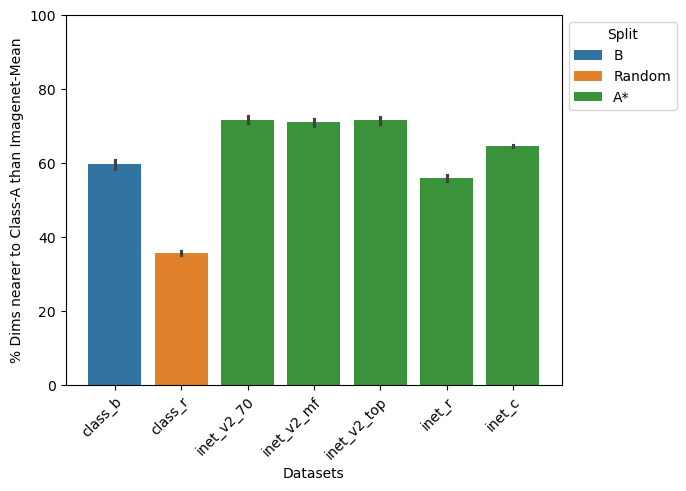

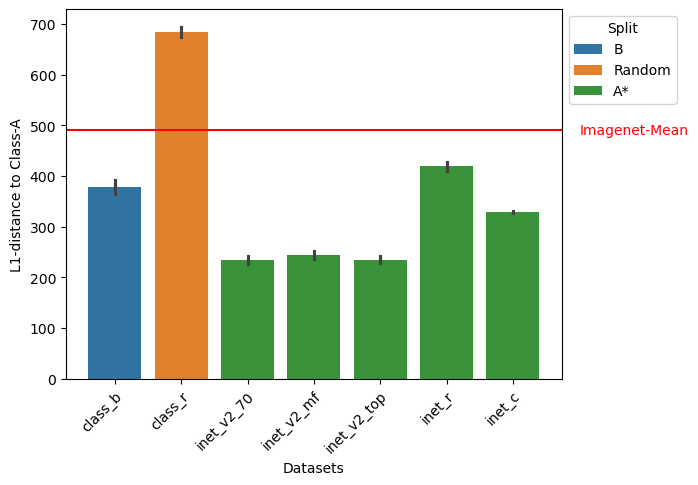

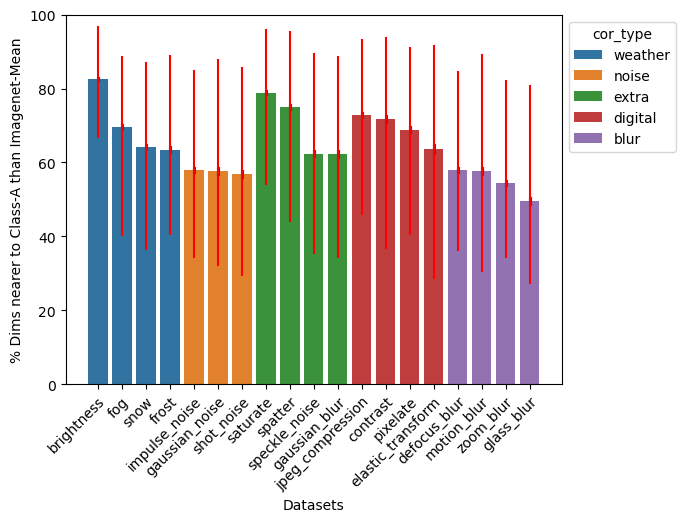

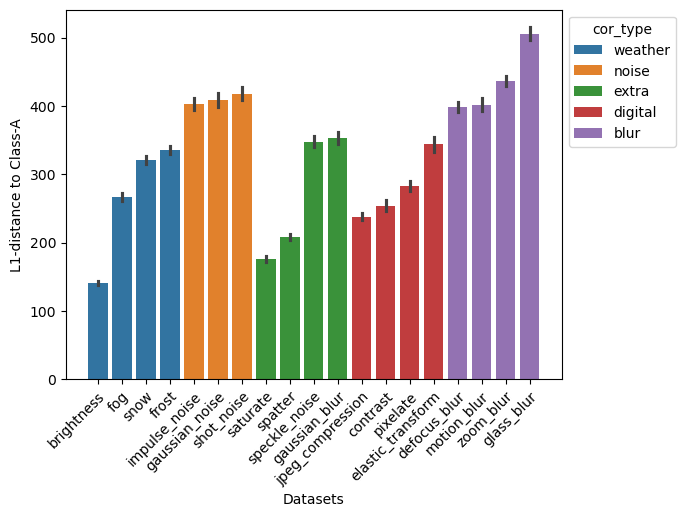

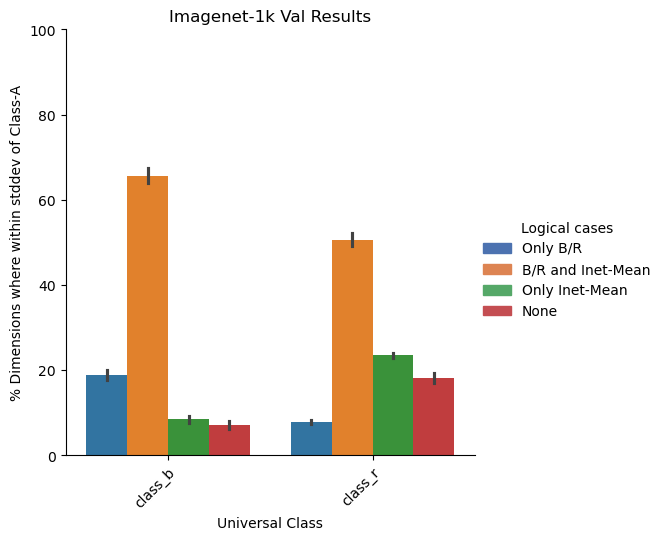

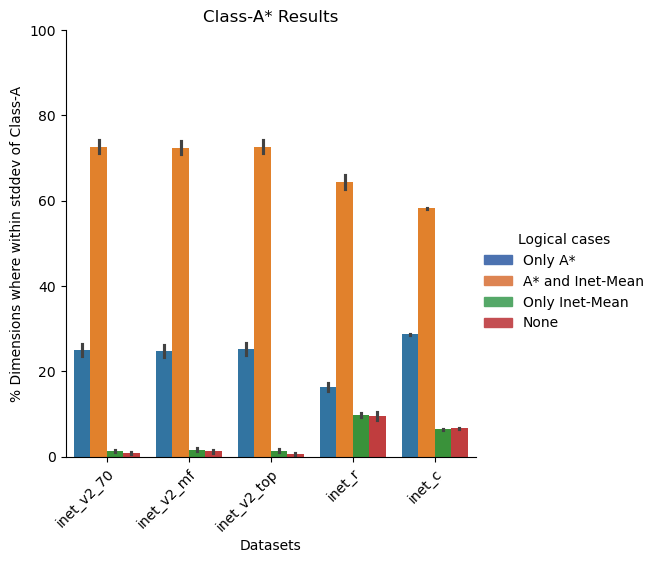

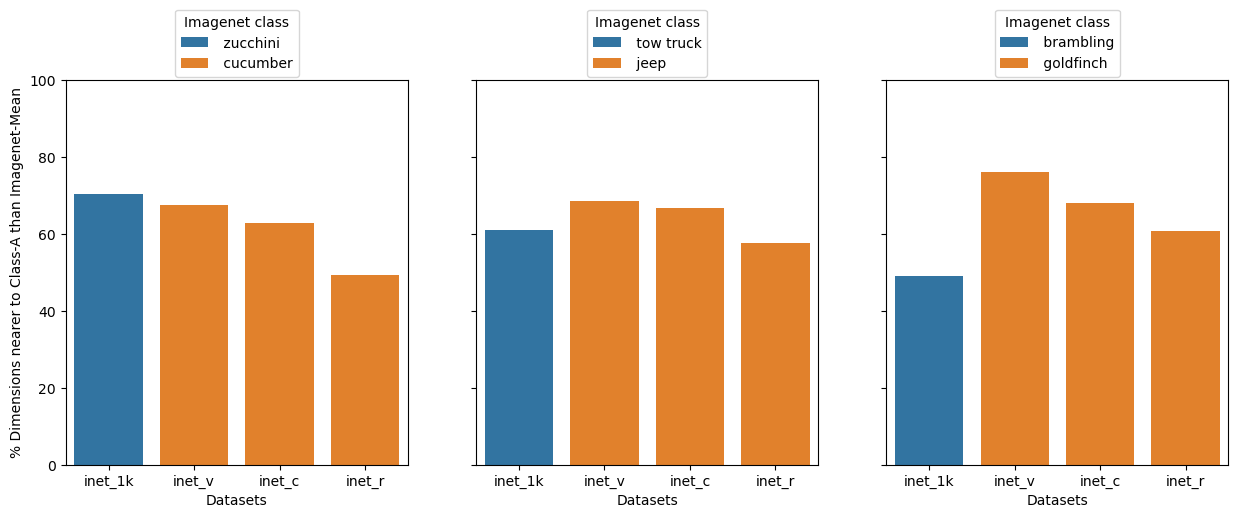

<Axes: xlabel='dataset', ylabel='dim_nearer'>

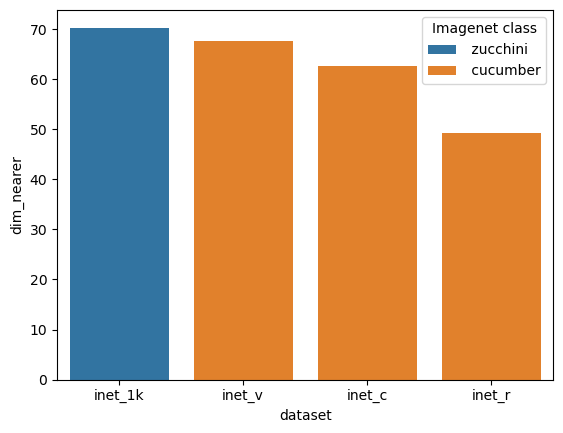

In [57]:
## ----- PLOTS ----- ##

df_basic_i_c = df_basic.loc[df_basic['dset']=='inet_c']
sns_plot = sns.barplot(data=df_basic, x='dset', y='dim_rel', hue='Split')
sns_plot.set(xlabel='Datasets', ylabel='% Dims nearer to Class-A than Imagenet-Mean')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.ylim((0, 100))
plt.plot()
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/overall_dims_nearer.svg', bbox_inches='tight')
plt.show()

sns_plot = sns.barplot(data=df_basic, x='dset', y='l1_dist', hue='Split')
sns_plot.set(xlabel='Datasets', ylabel='L1-distance to Class-A')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.axhline(y=inet_mean_l1_dist_mean, color='r')
plt.text(x=7, y=inet_mean_l1_dist_mean, verticalalignment='center', s='Imagenet-Mean', color='r')
plt.plot()
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/overall_l1_dist.svg', bbox_inches='tight')
plt.show()


sns_plot = sns.barplot(data=df_inet_c, x='cor_name', y='dim_rel', hue='cor_type')
sns_plot.set(xlabel='Datasets', ylabel='% Dims nearer to Class-A than Imagenet-Mean')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.vlines(x=x_cor_names, ymin=y_min_per_cor, ymax=y_max_per_cor, colors='red')
plt.ylim((0, 100))
plt.plot()
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/inet_c_dims_nearer.svg', bbox_inches='tight')
plt.show()

sns_plot = sns.barplot(data=df_inet_c, x='cor_name', y='l1_dist', hue='cor_type')
sns_plot.set(xlabel='Datasets', ylabel='L1-distance to Class-A')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.plot()
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/inet_c_l1_dist.svg', bbox_inches='tight')
plt.show()

df_melted_class_b_r = df_melted.loc[(df_melted['dset'] == 'class_b') | (df_melted['dset'] == 'class_r')]
df_melted_class_a_p = df_melted.loc[~((df_melted['dset'] == 'class_b') | (df_melted['dset'] == 'class_r'))]

log_cases_b_r = ['Only B/R', 'B/R and Inet-Mean', 'Only Inet-Mean', 'None']
log_cases_a_prime = ['Only A*', 'A* and Inet-Mean', 'Only Inet-Mean', 'None'] 
colors_b_r = sns.color_palette('deep').as_hex()[:len(log_cases_b_r)]
colors_a_prime = sns.color_palette('deep').as_hex()[:len(log_cases_a_prime)]
handles_b_r = [patches.Patch(color= col, label=lab) for col, lab in zip(colors_b_r, log_cases_b_r)]
handles_a_prime = [patches.Patch(color= col, label=lab) for col, lab in zip(colors_a_prime, log_cases_a_prime)]

facet_grid = sns.catplot(df_melted_class_b_r, kind='bar', x='dset', y='n_dims_rel', hue='split', legend=False)
facet_grid.set(xlabel='Universal Class', ylabel='% Dimensions where within stddev of Class-A')
facet_grid.add_legend(handles=handles_b_r, title='Logical cases', label_order=log_cases_b_r)
plt.ylim((0, 100))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Imagenet-1k Val Results')
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/class_b_r_within_stddev.svg', bbox_inches='tight')
plt.show()
facet_grid = sns.catplot(df_melted_class_a_p, kind='bar', x='dset', y='n_dims_rel', hue='split', legend=False)
facet_grid.set(xlabel='Datasets', ylabel='% Dimensions where within stddev of Class-A')
facet_grid.add_legend(handles=handles_a_prime, title='Logical cases', label_order=log_cases_a_prime)
plt.ylim((0, 100))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Class-A* Results')
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/class_a_prime_within_stddev.svg', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for n in range(3):
    sub_plot = sns.barplot(data=df_examples[n], ax=ax[n], x='dataset', y='dim_nearer', hue='Imagenet class')
    sns.move_legend(sub_plot, 'upper center', bbox_to_anchor=(0.5, 1.2))
    sub_plot.set(ylabel='% Dimensions nearer to Class-A than Imagenet-Mean', xlabel='Datasets')
    
plt.ylim((0, 100))
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/examples_dims_nearer.svg', bbox_inches='tight')
plt.show()

sns.barplot(data=df_examples[0], x='dataset', y='dim_nearer', hue='Imagenet class')